In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#%cd drive/MyDrive/Github/master_thesis
%cd drive/MyDrive/GitHub/master-thesis
from clustering.utils import *

/content/drive/MyDrive/GitHub/master-thesis


# Preprocessing

In [4]:
beh_cols = get_behaviour_cols()
df_pca_input = get_preprocessed_data(impute=True, impute_cols=beh_cols, start='2020-07-31', end='2021-02-02')

In [5]:
# Train Test Split
end_train = '2020-12-01'
df_pca_input_train = df_pca_input[(df_pca_input.date < end_train)]
max(df_pca_input_train.date)

Timestamp('2020-11-30 00:00:00')

In [39]:
scaler = MinMaxScaler()
pca_input_train = scaler.fit_transform(df_pca_input_train[beh_cols].to_numpy())
pca_input = scaler.fit_transform(df_pca_input[beh_cols].to_numpy())
pca_input.shape

(48933, 34)

In [48]:
pca_input_train = df_pca_input_train[beh_cols].to_numpy()

# PCA

In [42]:
pca = PCA(whiten=False)
pca.fit(pca_input_train)
x_pca = pca.transform(pca_input)
df_pca = pd.DataFrame(x_pca)
for column in df_pca.columns:
  df_pca.rename(columns={column: 'PC_'+str(column)}, inplace=True)
df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29,PC_30,PC_31,PC_32,PC_33
0,0.357542,-0.746448,0.653235,-0.417120,0.393775,0.452117,0.166616,0.223119,-0.196316,-0.113202,...,-0.793113,-0.395327,-0.454530,0.114734,-0.180208,0.159765,-0.598250,0.237102,0.078923,0.059856
1,1.471892,-0.351678,1.147680,1.159330,0.307483,0.204022,-0.050149,0.421346,-0.078933,0.546729,...,0.017667,-0.090770,-0.201951,-0.164535,0.216270,-0.319604,0.153496,-0.146569,0.201797,0.080518
2,-0.764400,-0.418198,-0.279406,0.161449,0.465871,0.589765,-0.466213,-0.442275,-0.093274,-0.059855,...,-0.462482,0.406555,-0.211454,-0.127513,-0.024112,-0.090594,-0.171655,-0.026390,-0.013381,0.019994
3,-0.885448,0.268040,-0.590044,0.404097,0.304489,-0.064908,-0.103152,0.221887,0.457426,-0.241808,...,0.010539,0.077834,-0.078324,0.084122,0.033191,-0.025879,0.006339,0.007168,0.004204,-0.001903
4,-1.096432,0.196243,0.391160,-0.004019,-0.233102,0.205484,-0.268105,-0.047639,0.168750,0.752848,...,0.005742,0.056633,0.010732,0.120168,0.026162,0.023789,0.053044,-0.008619,0.017385,-0.112726


# Evaluate Results

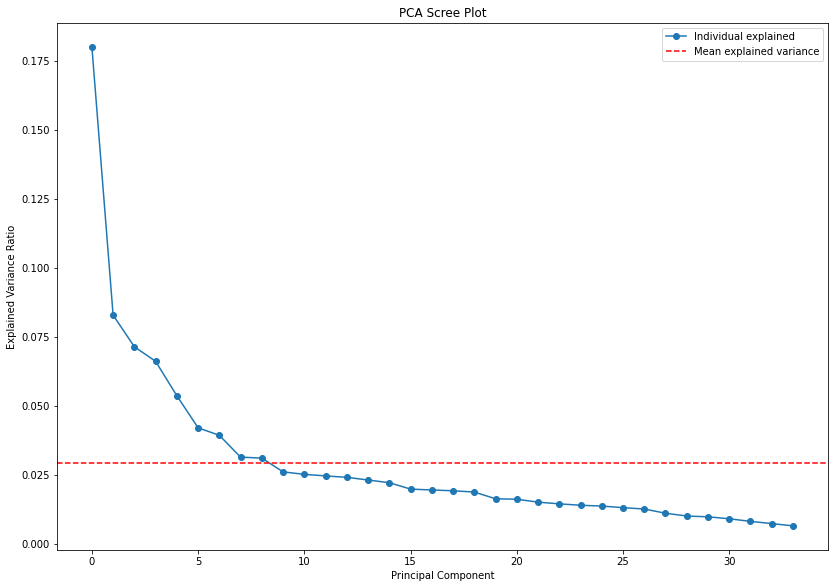

In [53]:
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#factor = 6.69287272 / exp_var_pca[0]
#exp_var_pca = exp_var_pca * factor
plt.plot(range(0,len(exp_var_pca)), exp_var_pca, label='Individual explained', marker='o')
#plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.axhline(y=exp_var_pca.mean(), color='r', linestyle='dashed', label='Mean explained variance')
plt.legend(loc='best')
plt.title('PCA Scree Plot')
plt.tight_layout()
plt.rcParams["figure.figsize"] = (11.7,8.27)
plt.show()

In [54]:
num_comp_avg = (exp_var_pca > exp_var_pca.mean()).sum()
explained_variance = cum_sum_eigenvalues[num_comp_avg-1]
print(f'{num_comp_avg} Komponenten sind größer als der Durchschnitt und erklären damit {np.round(explained_variance * 100, 2)}% der Varianz in den Daten.')

9 Komponenten sind größer als der Durchschnitt und erklären damit 59.81% der Varianz in den Daten.


In [56]:
num_comp = 6
cum_sum_eigenvalues

array([0.17995926, 0.26281088, 0.33424721, 0.400391  , 0.45407466,
       0.49616595, 0.53553018, 0.56700558, 0.59812553, 0.6242626 ,
       0.64949162, 0.67417281, 0.69833447, 0.72152709, 0.74373685,
       0.7636408 , 0.78321869, 0.80251507, 0.82135158, 0.83776022,
       0.85399156, 0.86917062, 0.88373135, 0.89778103, 0.91153778,
       0.92472095, 0.93741029, 0.94857204, 0.95873022, 0.96860381,
       0.97776629, 0.98598044, 0.99340339, 1.        ])

Die Dimensionen sollen soweit reduziert werden, dass noch 80% der Varianz benötigt werden.

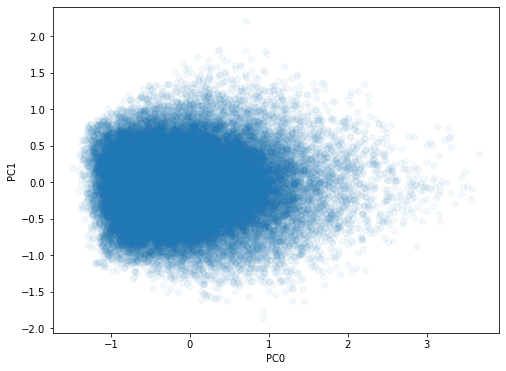

In [11]:
plt.scatter(x=df_pca['PC_0'], y=df_pca['PC_1'], alpha=0.05)
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.show()

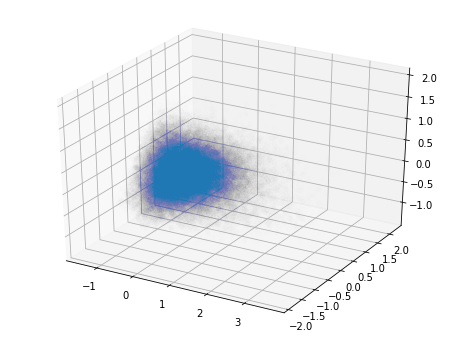

In [12]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df_pca['PC_0'], df_pca['PC_1'], df_pca['PC_2'], alpha=0.005)

# Write Data

In [57]:
col_names = df_pca.iloc[:,:num_comp].columns.tolist()
subset_drop = col_names + ['date']
df_pca_write = pd.concat([df_pca.iloc[:,:num_comp].copy(), df_pca_input], axis=1)
df_pca_write.dropna(subset=subset_drop, inplace=True)
df_pca_write.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46074 entries, 2 to 48932
Data columns (total 86 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   PC_0                                           46074 non-null  float64       
 1   PC_1                                           46074 non-null  float64       
 2   PC_2                                           46074 non-null  float64       
 3   PC_3                                           46074 non-null  float64       
 4   PC_4                                           46074 non-null  float64       
 5   PC_5                                           46074 non-null  float64       
 6   gender                                         46074 non-null  float64       
 7   postnr                                         46074 non-null  float64       
 8   region                                         46074 non

In [ ]:
#df_pca_write.to_csv('data/preprocessing/dim_reduction/220513_pca_data.csv', index=False)

# Evaluate PCA Components

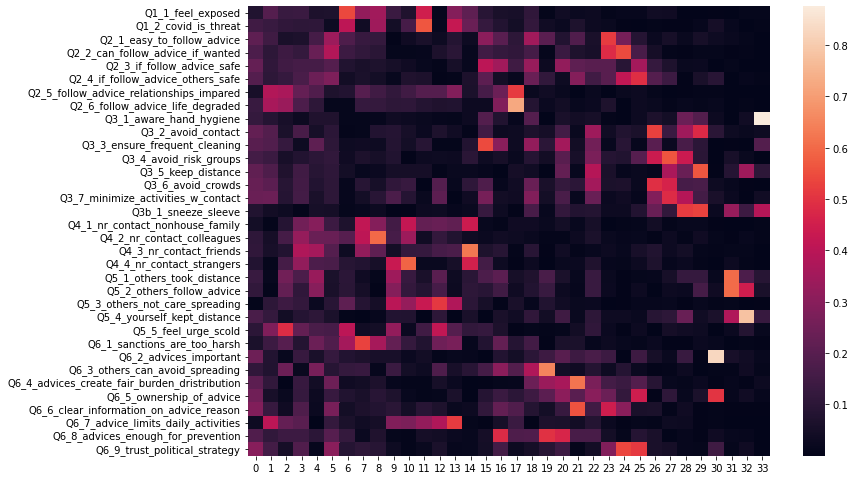

In [58]:
import seaborn as sns
df_components = pd.DataFrame(pca.components_, columns=beh_cols).transpose()
df_components = df_components.apply(lambda x: np.abs(x))
sns.heatmap(df_components) # .iloc[:,:nr_pc_80]

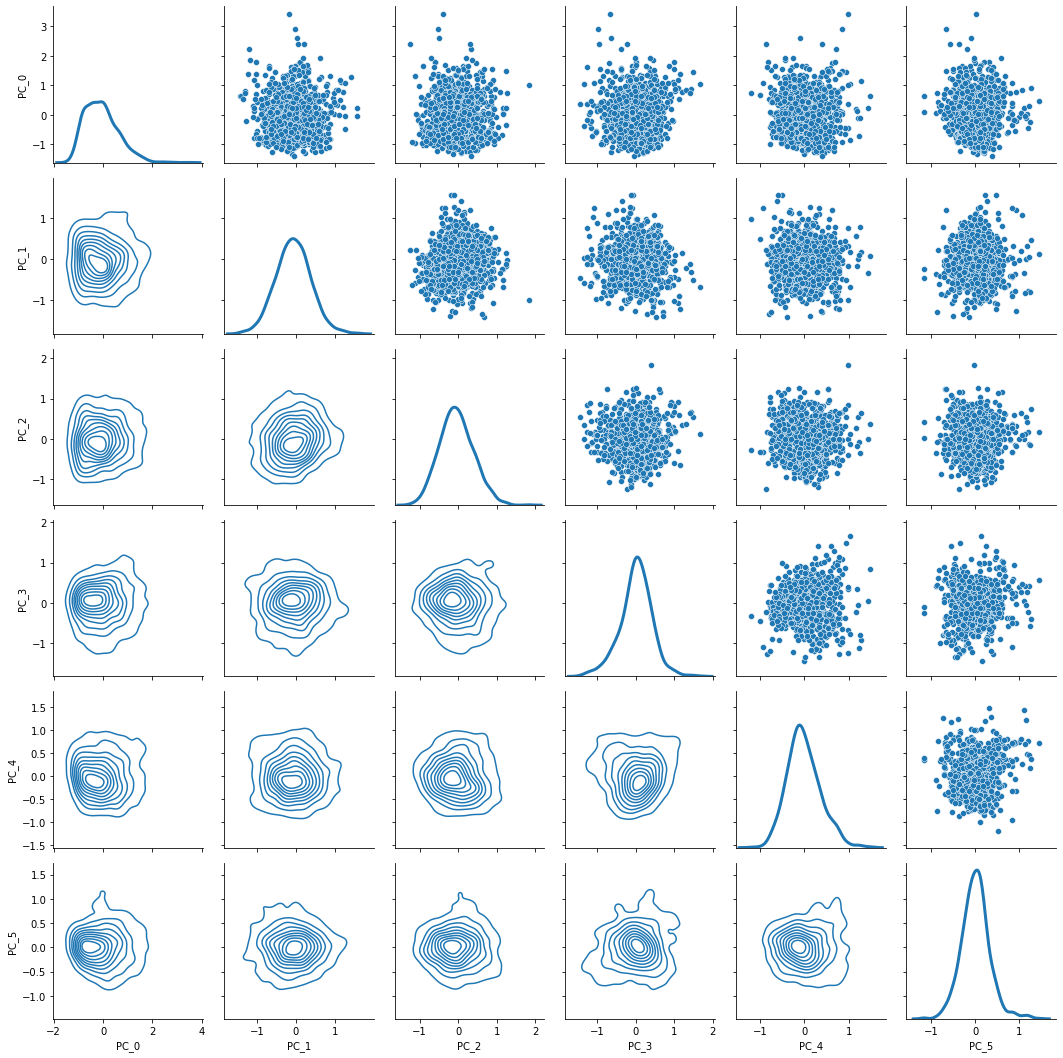

In [59]:
start = '2020-12-01'
end = '2020-12-07'
df_plot = df_pca_write.copy()
df_plot.date = pd.to_datetime(df_plot.date)
in_range = (df_plot.date > start) & (df_plot.date < end)
df_plot = df_plot[in_range]
df_plot = df_plot[col_names]
g = sns.PairGrid(data=df_plot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

In [60]:
import plotly.express as px
df_lineplot = df_pca_write[subset_drop].groupby('date').mean().reset_index()
df_lineplot[col_names] = df_lineplot[col_names].rolling(3).mean()
px.line(df_lineplot, x='date', y=col_names)